# Skill testing

- Models: ensemble average, reliability average, linear regression, delta method, NNGP, CNN
- Depths: l2 depth, linf depth, neighbor depth, 
- Shift: quantile corrected and uncorrected
- Variables: WN, TAS, TASMAX, PR

In [1]:
import os
import gc
import math

# numpy
import numpy as np
import scipy
np.set_printoptions(suppress=True)

# from jax
import jax
from jax import jacfwd, jacrev
from jax import vmap, grad, jit, random
from jax.config import config
import jax.numpy as jnp
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves

import haiku as hk
import flax
from flax import linen as nn
import optax
config.update("jax_enable_x64", True)

# plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import FormatStrFormatter
plt.style.use('default')

from matplotlib.gridspec import GridSpec
from matplotlib import colors
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from tqdm.notebook import tqdm
from tqdm.notebook import trange

# netCDF
import netCDF4 as nc
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import PCA

In [2]:
def scale_and_split(xtrain, xtest, model_no, nval = 200):
    ytrain = xtrain[:,model_no]
    ytest = xtest[:,model_no]
    xtrain = np.delete(xtrain, model_no, axis=1)
    xtest = np.delete(xtest, model_no, axis=1)

    ## dimensions
    ntrain = xtrain.shape[0]
    ntest = xtest.shape[0]
    nlat = xtrain.shape[2]
    nlon = xtrain.shape[3]

    ## rescale
    xtrain_mean = np.mean(xtrain, axis = 1)
    xtest_mean = np.mean(xtest, axis = 1)
    xtrain_sd = np.std(xtrain, axis = 1)
    xtest_sd = np.std(xtest, axis = 1)

    xtrain_scaled = (xtrain - xtrain_mean[:,None]) / xtrain_sd[:,None]
    xtest_scaled = (xtest - xtest_mean[:,None]) / xtest_sd[:,None]
    ytrain_scaled = (ytrain - xtrain_mean) / xtrain_sd
    ytest_scaled = (ytest - xtest_mean) / xtest_sd

    xval_scaled = xtrain_scaled[-nval:]
    yval_scaled = ytrain_scaled[-nval:]
    xtrain_scaled = xtrain_scaled[:-nval]
    ytrain_scaled = ytrain_scaled[:-nval]
    
    out = [xtrain_scaled, xval_scaled, xtest_scaled,
            ytrain_scaled, yval_scaled, ytest_scaled,
            xtrain_mean, xtest_mean, xtrain_sd, xtest_sd]
    out = [np.float32(x) for x in out]
    return out

def anomalize(xtrain, xtest):
    xtrain_anom = np.zeros_like(xtrain)
    xtest_anom = np.zeros_like(xtest)

    ntrain = xtrain.shape[0]
    ntest = xtest.shape[0]

    monthly_means = np.array([np.mean(xtrain[(12*20):(12*50)][i::12], axis = 0) for i in range(12)])
    for k in trange(ntrain, leave = False):
        xtrain_anom[k] = xtrain[k] - monthly_means[k % 12]

    for k in trange(ntest, leave = False):
        xtest_anom[k] = xtest[k] - monthly_means[k % 12]
    
    return np.array(xtrain_anom), np.array(xtest_anom)

In [3]:
def inf_depth(x, y):
    dist = jnp.max(jnp.abs(y), axis = (1, 2))
    return 1/(1 + dist)
inf_depth = jit(inf_depth)

def global_mmd(x, y):
    dist = jnp.max(jnp.abs(x - y), axis = (1, 2))
    dist = jnp.mean(dist)
    return 1/(1 + dist)
global_mmd = jit(vmap(global_mmd, (None, 0)))

def global_mmd_self(x, y):
    dist = jnp.max(jnp.abs(x - y), axis = (1, 2))
    dist = jnp.mean(jnp.sort(dist)[1:])
    return 1/(1 + dist)
global_mmd_self = jit(vmap(global_mmd_self, (None, 0)))

def field_min(x, y):
    return jnp.min(jnp.array([x, y]))
field_min = jit(vmap(vmap(field_min, (0, 0)), (1, 1)))

def tukey_depth(x, y):
    fx_left = jnp.mean(x < y, axis = 0)
    fx_right = jnp.mean(x > y, axis = 0)
    return jnp.mean(2 * field_min(fx_left, fx_right))
tukey_depth = jit(vmap(tukey_depth, (None, 0)))

def tukey_depth_self(x, y):
    fx_left = jnp.sum(x < y, axis = 0)/(x.shape[0] - 1)
    fx_right = jnp.sum(x > y, axis = 0)/(x.shape[0] - 1)
    return jnp.mean(2 * field_min(fx_left, fx_right))
tukey_depth_self = jit(vmap(tukey_depth_self, (None, 0)))

def conformal_ensemble(resval, depth_fn, alpha):
    nval = resval.shape[0]
    level = np.ceil((1 - alpha) * (nval + 1))/(nval + 1)
    dr1 = 1 - depth_fn(resval, resval)
    q = np.sort(dr1)[int(np.ceil((1 - alpha) * (nval + 1)))]
    q = (q + np.quantile(dr1, level))/2
    return resval[dr1 < q]

In [4]:
def quantile_interp(model, model_quant, ref_quant):
    return jnp.interp(model, model_quant, ref_quant)
quantile_interp = vmap(quantile_interp, (1, 1, 1))
quantile_interp = vmap(quantile_interp, (1, 1, 1))
quantile_interp = jit(quantile_interp)

def quantile_map(ref, model_hist, model_future):
    ref_quant = jnp.quantile(ref, jnp.linspace(0, 1, 20), axis = 0)
    model_quant = jnp.quantile(model_hist, jnp.linspace(0, 1, 20), axis = 0)
    corrected_model = quantile_interp(model_future, model_quant, ref_quant)
    return jnp.moveaxis(corrected_model, 2, 0)
quantile_map = jit(quantile_map)

In [5]:
### model init

def nngp_params(key, depth = 1):

    subkeys = random.split(key, 3 + 2 * (depth - 1))

    base_layer = jnp.array([random.uniform(subkeys[0], minval = 0.75, maxval = 1.25), 
                            random.uniform(subkeys[1], minval = 0.1, maxval = 0.5),
                            random.uniform(subkeys[2], minval = 0.2, maxval = 0.7)])
    base_layer = [tuple(base_layer)]

    return base_layer
parallel_nngp_params = vmap(nngp_params, in_axes=(0, None))


def random_params(key, depth):
    nngp_par = nngp_params(key, depth)
    trend_par = trend_params(key)
    
    return [nngp_par, trend_par]
parallel_params = vmap(random_params, in_axes=(0, None))

@jit
def random_init(params):
    return opt_init(params)
parallel_init = vmap(random_init)

@jit
def param_abs(x):
    return jnp.abs(x)

@jit
def param_select(param_list, i):
    return tree_map(lambda x: x[i], param_list)


### model specification

depth = 7

## nngp functions
def nngp_kernel(params, x, y):
    x = jnp.array(x)
    y = jnp.array(y)
    
    kxx = params[0][1] + params[0][0] * (jnp.dot(x, x.T) / x.shape[0])
    kyy = params[0][1] + params[0][0] * (jnp.dot(y, y.T) / x.shape[0])
    kxy = params[0][1] + params[0][0] * (jnp.dot(x, y.T) / x.shape[0])
    
    for i in range(depth):
        
        ## kxy
        cor = jnp.clip(kxy / jnp.sqrt(kxx * kyy), -1.0 + 1e-16, 1.0 - 1e-16)
        theta = jnp.arccos(cor)
        trig = jnp.sin(theta) + (math.pi - theta) * jnp.cos(theta)
        kxy = params[0][1] + (params[0][0] / (2 * math.pi)) * jnp.sqrt(kxx * kyy) * trig
                
        ## kxx
        kxx = params[0][1] + (params[0][0] / 2) * kxx
    
        ## kyy
        kyy = params[0][1] + (params[0][0] / 2) * kyy
        
    return kxy

nngp_kernel = jit(nngp_kernel)
nngp_cov = jit(vmap(vmap(nngp_kernel, (None, None, 0)), (None, 0, None)))
nngp_var = jit(vmap(nngp_kernel, (None, 0, 0)))


def nngp_predict(params, xtest, xtrain, ytrain):
    n, p = ytrain.shape
        
    k_DD0 = nngp_cov(params, xtrain, xtrain)
    k_DD0 += jnp.diag(jnp.repeat(params[0][2], n))
    prec0 = jnp.linalg.inv(k_DD0)
    
    k_xD0 = nngp_cov(params, xtest, xtrain)
    
    proj0 = jnp.matmul(k_xD0, prec0)
    return jnp.matmul(proj0, ytrain)
nngp_predict = jit(nngp_predict)


def nngp_dist(params, xtest, xtrain, ytrain):
    n, p = ytrain.shape
        
    k_DD0 = nngp_cov(params, xtrain, xtrain)
    k_DD0 += jnp.diag(jnp.repeat(params[0][2], n))
    prec0 = jnp.linalg.inv(k_DD0)
    
    k_xD0 = nngp_cov(params, xtest, xtrain)
    proj0 = jnp.matmul(k_xD0, prec0)
    
    mu = jnp.matmul(proj0, ytrain)
    
    k_xx = nngp_var(params, xtest, xtest)
    sig = k_xx - jnp.sum(proj0 * k_xD0, axis = 1)
    
    return mu, sig
nngp_dist = jit(nngp_dist)


#### loss functions

def compute_lr(pgrad, scale = 2):
    leaves = jnp.array(tree_leaves(pgrad))
    lrs = 10**(-jnp.floor(jnp.log10(jnp.abs(leaves))) - scale)
    return lrs

def weighted_mse(k_inv, ytrain):
    return jnp.matmul(jnp.matmul(ytrain.T, k_inv), ytrain)
weighted_mse = jit(vmap(weighted_mse, (None, 1)))


def full_nll_loss(params, xtrain, ytrain):
    n, p = ytrain.shape

    k = nngp_cov(params, xtrain, xtrain)
    k += jnp.diag(jnp.repeat(params[0][2], n))
    k_inv = jnp.linalg.inv(k)
    
    mse = jnp.sum(weighted_mse(k_inv, ytrain))
    pen = p * jnp.linalg.slogdet(k)[1]
    nor = p/2 * jnp.log(2 * math.pi)
    return (0.5*mse + 0.5*pen + nor) / p
full_grad_loss = jit(grad(full_nll_loss))


def gradient_step(params, xtrain, ytrain):
        
    param, tdef = tree_flatten(params)
    pgrad = tree_flatten(full_grad_loss(params, xtrain, ytrain))[0]
    
    lrs = compute_lr(pgrad, 3)
    param = [a - lr * b for a, b, lr in zip(tree_leaves(param), pgrad, lrs)]

    params = tree_unflatten(tdef, param)
    params = tree_map(param_abs, params)
    return params
gradient_step = jit(gradient_step)
# parallel_gradient_step = vmap(gradient_step, in_axes = (0, None, None))

In [6]:
def slices(nlat, nlon, seed = 0):
    np.random.seed(seed)
    w = np.random.normal(0,1, [500, nlat*nlon])
    w = w / np.sqrt(np.sum(w**2, axis = 1))[:,None]
    return w

def sw2(x, y, w):
    x = x.reshape(-1, nlat*nlon)
    y = y.reshape(-1, nlat*nlon)
    
    x = x @ w.T
    y = y @ w.T
    
    qx = jnp.quantile(x, jnp.linspace(0, 1, 50), axis = 0)
    qy = jnp.quantile(y, jnp.linspace(0, 1, 50), axis = 0)
    return jnp.mean(jnp.sqrt(jnp.mean((qx - qy)**2, axis = 0)))

sw2 = jit(sw2)


def w2(x, y):
    qx = jnp.quantile(x, jnp.linspace(0.005, 0.995, 100), axis = 0)
    qy = jnp.quantile(y, jnp.linspace(0.005, 0.995, 100), axis = 0)
    return jnp.sqrt(jnp.mean((qx - qy)**2))

w2 = vmap(w2, (1, 1))
w2 = vmap(w2, (1, 1))
w2 = jit(w2)

def _crps(ens, y): 
    lb = jnp.min(jnp.array([jnp.min(ens), jnp.min(y)]))
    ub = jnp.max(jnp.array([jnp.max(ens), jnp.max(y)]))
    cdf_a = jnp.array([jnp.mean(x > ens) for x in jnp.linspace(lb, ub, 50)])
    cdf_b = jnp.array([jnp.mean(x > y) for x in jnp.linspace(lb, ub, 50)])
    return jnp.sqrt(jnp.mean((cdf_a - cdf_b)**2))
crps = vmap(_crps, (1, 1))
crps = vmap(crps, (1, 1))
crps = jit(crps)

def _pit(ensemble, y):
    pit = jnp.mean(jnp.array(ensemble[None,:] < y[:,None]).squeeze(), axis = 1)
    pit_cdf = jnp.array([jnp.mean(pit < x, axis = 0) for x in np.linspace(0, 1, 50)])
    uni_cdf = jnp.linspace(0, 1, 50)[:,None,None]
    pit_score = jnp.sqrt(jnp.mean((pit_cdf - uni_cdf)**2, axis = 0))
    return pit_score
pit = jit(_pit)

def boot(x):
    n = x.shape[0]
    idx = np.random.choice(n, n, replace = True)
    return x[idx]

def shuffle(x):
    n = x.shape[0]
    idx = np.random.choice(n, n, replace = False)
    return x[idx]

def moving_average(a, n=12):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def mse_weighted(x, y):
    nlat = x.shape[1]
    weight = np.cos(np.linspace(math.pi/2 - 1/nlat, -math.pi/2 + 1/nlat, nlat))
    weight /= np.mean(weight)
    weight = weight[None,:,None]
    
    return np.sqrt(np.mean((x - y)**2 * weight, axis = (1, 2)))

## Metrics

## tas

In [7]:
nproj = 6

xhist_tas = pickle.load(open('../data/xhist_tas_hr.pkl', 'rb'))
xrcp_tas = pickle.load(open('../data/xrcp_tas_hr.pkl', 'rb'))
nmod = xhist_tas.shape[1]
nlat, nlon = xhist_tas[0].shape[1:]

n = (2015 - 1940) * 12
xhist_tas = xhist_tas[-n:]

xtrain_orig = np.concatenate([xhist_tas, xrcp_tas[:108]], axis = 0)
xtest_orig = xrcp_tas[108:]

# ntrain = xtrain_orig.shape[0] - nval
# ntest = xtest_orig.shape[0]

save_loc = 'trained_models/tas'

xtrain_anom, xtest_anom = anomalize(xtrain_orig, xtest_orig)
xtrain_anom = jnp.array(xtrain_anom)
xtest_anom = jnp.array(xtest_anom)
del xtrain_orig, xtest_orig

  0%|          | 0/1008 [00:00<?, ?it/s]

  0%|          | 0/912 [00:00<?, ?it/s]

In [ ]:
analysis = ['ens', 'wa', 'delta', 'lm', 'nngp', 'cnn1']
nproj = len(analysis)
w = slices(nlat, nlon)

weight = jnp.cos(jnp.linspace(math.pi/2 - 1/nlat, -math.pi/2 + 1/nlat, nlat))
weight = weight / jnp.mean(weight)
weight = weight[None,:,None]
weight = np.float32(weight)

nvals = np.arange(50, 500, 50)
tas_results = np.zeros((nmod, len(nvals), 2))

for model_no in trange(nmod):
    for i in trange(len(nvals), leave = False):
        
        nval = nvals[i]
    
        _data = scale_and_split(xtrain_anom, xtest_anom, model_no = model_no, nval = nval)

        xtrain = _data[0]
        xval = _data[1]
        xtest = _data[2]
        ytrain = _data[3]
        yval = _data[4]
        ytest = _data[5]
        xtrain_mean = _data[6]
        xtest_mean = _data[7]
        xtrain_sd = _data[8]
        xtest_sd = _data[9]

        ntrain = xtrain.shape[0]
        ntest = xtest.shape[0]
        
        #### Ens average
        yval_hat = np.mean(xval, axis = 1)
        ytest_hat = np.mean(xtest, axis = 1)
        yval_hat = jnp.float32(jnp.array(yval_hat))
        ytest_hat = jnp.float32(jnp.array(ytest_hat))

        yval2 = xtrain_sd[-nval:] * yval + xtrain_mean[-nval:]
        yval_hat = xtrain_sd[-nval:] * yval_hat + xtrain_mean[-nval:]

        xtest2 = xtest_sd[:,None] * xtest + xtest_mean[:,None]
        ytest2 = xtest_sd * ytest + xtest_mean
        ytest_hat = xtest_sd * ytest_hat + xtest_mean
        
        resval = yval2 - yval_hat
        restest = ytest2 - ytest_hat

        depth_fns = [global_mmd_self, tukey_depth_self, inf_depth]
        conf_ens1 = conformal_ensemble(resval, depth_fns[0], 0.1)

        tas_results[model_no, i, 0] = sw2(conf_ens1, restest, w)
        
        
        #### NNGP
        key = random.PRNGKey(1023)
        params = nngp_params(key, depth)
        for _ in trange(100, leave = False):
            params = gradient_step(params, xtrain.reshape(ntrain, -1), ytrain.reshape(ntrain, -1))

        yval_hat = nngp_predict(params, xval.reshape(nval, -1), xtrain.reshape(ntrain, -1), ytrain.reshape(ntrain, -1))
        ytest_hat = nngp_predict(params, xtest.reshape(ntest, -1), xtrain.reshape(ntrain, -1), ytrain.reshape(ntrain, -1))
        yval_hat = yval_hat.reshape(-1, nlat, nlon)
        ytest_hat = ytest_hat.reshape(-1, nlat, nlon)
        
        yval_hat = xtrain_sd[-nval:] * yval_hat + xtrain_mean[-nval:]
        ytest_hat = xtest_sd * ytest_hat + xtest_mean        

        resval = yval2 - yval_hat
        restest = ytest2 - ytest_hat

        conf_ens1 = conformal_ensemble(resval, depth_fns[0], 0.1)

        tas_results[model_no, i, 1] = sw2(conf_ens1, restest, w)
        
        np.save('./tas_valsize', tas_results)

In [8]:
tas_results = np.load('./tas_valsize.npy')
tas_nmod = tas_results.shape[0]
nvals = np.arange(50, 500, 50)

In [9]:
# analysis = ['EA', 'WA', 'Delta', 'LM', 'GP', 'CNN']
tas_mu = np.mean(tas_results, axis = 0).T
tas_sd = np.std(tas_results, axis = 0).T / np.sqrt(tas_nmod)

In [10]:
# plt.plot(nvals, tas_mu[0], c = 'C0')
# plt.plot(nvals, tas_mu[0] + 2 * tas_sd[0], c = 'C0')
# plt.plot(nvals, tas_mu[0] - 2 * tas_sd[0], c = 'C0')
# plt.plot(nvals, tas_mu[1], c = 'C1')
# plt.plot(nvals, tas_mu[1] + 2 * tas_sd[1], c = 'C1')
# plt.plot(nvals, tas_mu[1] - 2 * tas_sd[1], c = 'C1')
# plt.show()

## tmax

In [11]:
nproj = 6
nval = 200

xhist_tas = pickle.load(open('../data/xhist_tasmax_hr.pkl', 'rb'))
xrcp_tas = pickle.load(open('../data/xrcp_tasmax_hr.pkl', 'rb'))
nmod = xhist_tas.shape[1]
nlat, nlon = xhist_tas.shape[2:]

n = (2015 - 1940) * 12
xhist_tas = xhist_tas[-n:]

xtrain_orig = np.concatenate([xhist_tas, xrcp_tas[:108]], axis = 0)
xtest_orig = xrcp_tas[108:]

ntrain = xtrain_orig.shape[0] - nval
ntest = xtest_orig.shape[0]

save_loc = 'trained_models/tmax'

xtrain_anom, xtest_anom = anomalize(xtrain_orig, xtest_orig)
xtrain_anom = np.array(xtrain_anom)
xtest_anom = np.array(xtest_anom)
del xtrain_orig, xtest_orig

  0%|          | 0/1008 [00:00<?, ?it/s]

  0%|          | 0/924 [00:00<?, ?it/s]

In [29]:
analysis = ['ens', 'wa', 'delta', 'lm', 'nngp', 'cnn1']
nproj = len(analysis)
w = slices(nlat, nlon)

weight = jnp.cos(jnp.linspace(math.pi/2 - 1/nlat, -math.pi/2 + 1/nlat, nlat))
weight = weight / jnp.mean(weight)
weight = weight[None,:,None]
weight = np.float32(weight)

nvals = np.arange(50, 500, 50)
tmax_results = np.zeros((nmod, len(nvals), 2))

for model_no in trange(nmod):
    for i in trange(len(nvals), leave = False):
        
        nval = nvals[i]
    
        _data = scale_and_split(xtrain_anom, xtest_anom, model_no = model_no, nval = nval)

        xtrain = _data[0]
        xval = _data[1]
        xtest = _data[2]
        ytrain = _data[3]
        yval = _data[4]
        ytest = _data[5]
        xtrain_mean = _data[6]
        xtest_mean = _data[7]
        xtrain_sd = _data[8]
        xtest_sd = _data[9]

        ntrain = xtrain.shape[0]
        ntest = xtest.shape[0]
        
        #### Ens average
        yval_hat = np.mean(xval, axis = 1)
        ytest_hat = np.mean(xtest, axis = 1)
        yval_hat = jnp.float32(jnp.array(yval_hat))
        ytest_hat = jnp.float32(jnp.array(ytest_hat))

        yval2 = xtrain_sd[-nval:] * yval + xtrain_mean[-nval:]
        yval_hat = xtrain_sd[-nval:] * yval_hat + xtrain_mean[-nval:]

        xtest2 = xtest_sd[:,None] * xtest + xtest_mean[:,None]
        ytest2 = xtest_sd * ytest + xtest_mean
        ytest_hat = xtest_sd * ytest_hat + xtest_mean
        
        resval = yval2 - yval_hat
        restest = ytest2 - ytest_hat

        depth_fns = [global_mmd_self, tukey_depth_self, inf_depth]
        conf_ens1 = conformal_ensemble(resval, depth_fns[0], 0.1)

        tmax_results[model_no, i, 0] = sw2(conf_ens1, restest, w)
        
        
        #### NNGP
        key = random.PRNGKey(1023)
        params = nngp_params(key, depth)
        for _ in trange(100, leave = False):
            params = gradient_step(params, xtrain.reshape(ntrain, -1), ytrain.reshape(ntrain, -1))

        yval_hat = nngp_predict(params, xval.reshape(nval, -1), xtrain.reshape(ntrain, -1), ytrain.reshape(ntrain, -1))
        ytest_hat = nngp_predict(params, xtest.reshape(ntest, -1), xtrain.reshape(ntrain, -1), ytrain.reshape(ntrain, -1))
        yval_hat = yval_hat.reshape(-1, nlat, nlon)
        ytest_hat = ytest_hat.reshape(-1, nlat, nlon)
        
        yval_hat = xtrain_sd[-nval:] * yval_hat + xtrain_mean[-nval:]
        ytest_hat = xtest_sd * ytest_hat + xtest_mean        

        resval = yval2 - yval_hat
        restest = ytest2 - ytest_hat

        conf_ens1 = conformal_ensemble(resval, depth_fns[0], 0.1)

        tmax_results[model_no, i, 1] = sw2(conf_ens1, restest, w)
        
        np.save('./tmax_valsize', tmax_results)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [12]:
tmax_results = np.load('./tmax_valsize.npy')
tmax_nmod = tmax_results.shape[0]
nvals = np.arange(50, 500, 50)

In [13]:
tmax_mu = np.mean(tmax_results, axis = 0).T
tmax_sd = np.std(tmax_results, axis = 0).T / np.sqrt(tmax_nmod)

In [15]:
# plt.plot(nvals, tmax_mu[0], c = 'C0')
# plt.plot(nvals, tmax_mu[0] + 2 * tmax_sd[0], c = 'C0')
# plt.plot(nvals, tmax_mu[0] - 2 * tmax_sd[0], c = 'C0')
# plt.plot(nvals, tmax_mu[1], c = 'C1')
# plt.plot(nvals, tmax_mu[1] + 2 * tmax_sd[1], c = 'C1')
# plt.plot(nvals, tmax_mu[1] - 2 * tmax_sd[1], c = 'C1')
# plt.show()

## pr

In [16]:
nproj = 6
nval = 200

xhist_tas = pickle.load(open('../data/xhist_pr_hr.pkl', 'rb'))
xrcp_tas = pickle.load(open('../data/xrcp_pr_hr.pkl', 'rb'))
nmod = xhist_tas.shape[1]
nlat, nlon = xhist_tas[0].shape[1:]

n = (2015 - 1940) * 12
xhist_tas = xhist_tas[-n:]

xtrain_orig = np.concatenate([xhist_tas, xrcp_tas[:108]], axis = 0)
xtest_orig = xrcp_tas[108:]

ntrain = xtrain_orig.shape[0] - nval
ntest = xtest_orig.shape[0]

xtrain_orig = np.log(np.abs(xtrain_orig) + 1e-3)
xtest_orig = np.log(np.abs(xtest_orig) + 1e-3)

xtrain_orig = np.float32(xtrain_orig)
xtest_orig = np.float32(xtest_orig)

save_loc = 'trained_models/pr'

xtrain_anom, xtest_anom = anomalize(xtrain_orig, xtest_orig)
xtrain_anom = np.array(xtrain_anom)
xtest_anom = np.array(xtest_anom)
del xtrain_orig, xtest_orig

  0%|          | 0/1008 [00:00<?, ?it/s]

  0%|          | 0/912 [00:00<?, ?it/s]

In [13]:
analysis = ['ens', 'wa', 'delta', 'lm', 'nngp', 'cnn1']
nproj = len(analysis)
w = slices(nlat, nlon)

weight = jnp.cos(jnp.linspace(math.pi/2 - 1/nlat, -math.pi/2 + 1/nlat, nlat))
weight = weight / jnp.mean(weight)
weight = weight[None,:,None]
weight = np.float32(weight)

nvals = np.arange(50, 500, 50)
pr_results = np.zeros((nmod, len(nvals), 2))

for model_no in trange(nmod):
    for i in trange(len(nvals), leave = False):
        
        nval = nvals[i]
    
        _data = scale_and_split(xtrain_anom, xtest_anom, model_no = model_no, nval = nval)

        xtrain = _data[0]
        xval = _data[1]
        xtest = _data[2]
        ytrain = _data[3]
        yval = _data[4]
        ytest = _data[5]
        xtrain_mean = _data[6]
        xtest_mean = _data[7]
        xtrain_sd = _data[8]
        xtest_sd = _data[9]

        ntrain = xtrain.shape[0]
        ntest = xtest.shape[0]
        
        #### Ens average
        yval_hat = np.mean(xval, axis = 1)
        ytest_hat = np.mean(xtest, axis = 1)
        yval_hat = jnp.float32(jnp.array(yval_hat))
        ytest_hat = jnp.float32(jnp.array(ytest_hat))

        yval2 = xtrain_sd[-nval:] * yval + xtrain_mean[-nval:]
        yval_hat = xtrain_sd[-nval:] * yval_hat + xtrain_mean[-nval:]

        xtest2 = xtest_sd[:,None] * xtest + xtest_mean[:,None]
        ytest2 = xtest_sd * ytest + xtest_mean
        ytest_hat = xtest_sd * ytest_hat + xtest_mean
        
        resval = yval2 - yval_hat
        restest = ytest2 - ytest_hat

        depth_fns = [global_mmd_self, tukey_depth_self, inf_depth]
        conf_ens1 = conformal_ensemble(resval, depth_fns[0], 0.1)

        pr_results[model_no, i, 0] = sw2(conf_ens1, restest, w)
        
        
        #### NNGP
        key = random.PRNGKey(1023)
        params = nngp_params(key, depth)
        for _ in trange(100, leave = False):
            params = gradient_step(params, xtrain.reshape(ntrain, -1), ytrain.reshape(ntrain, -1))

        yval_hat = nngp_predict(params, xval.reshape(nval, -1), xtrain.reshape(ntrain, -1), ytrain.reshape(ntrain, -1))
        ytest_hat = nngp_predict(params, xtest.reshape(ntest, -1), xtrain.reshape(ntrain, -1), ytrain.reshape(ntrain, -1))
        yval_hat = yval_hat.reshape(-1, nlat, nlon)
        ytest_hat = ytest_hat.reshape(-1, nlat, nlon)
        
        yval_hat = xtrain_sd[-nval:] * yval_hat + xtrain_mean[-nval:]
        ytest_hat = xtest_sd * ytest_hat + xtest_mean        

        resval = yval2 - yval_hat
        restest = ytest2 - ytest_hat

        conf_ens1 = conformal_ensemble(resval, depth_fns[0], 0.1)

        pr_results[model_no, i, 1] = sw2(conf_ens1, restest, w)
        
        np.save('./pr_valsize', pr_results)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [17]:
pr_results = np.load('./pr_valsize.npy')
pr_nmod = pr_results.shape[0]
nvals = np.arange(50, 500, 50)

In [18]:
pr_mu = np.mean(pr_results, axis = 0).T
pr_sd = np.std(pr_results, axis = 0).T / np.sqrt(pr_nmod)

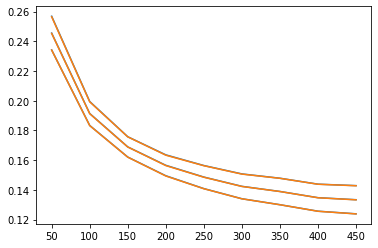

In [19]:
plt.plot(nvals, pr_mu[0], c = 'C0')
plt.plot(nvals, pr_mu[0] + 2 * pr_sd[0], c = 'C0')
plt.plot(nvals, pr_mu[0] - 2 * pr_sd[0], c = 'C0')
plt.plot(nvals, pr_mu[1], c = 'C1')
plt.plot(nvals, pr_mu[1] + 2 * pr_sd[1], c = 'C1')
plt.plot(nvals, pr_mu[1] - 2 * pr_sd[1], c = 'C1')
plt.show()

In [20]:
mu = [tas_mu, tmax_mu, pr_mu]
se = [tas_sd, tmax_sd, pr_sd]
nvals = np.arange(50, 500, 50)

In [22]:
# nvals[np.argmin(mean_ea)]

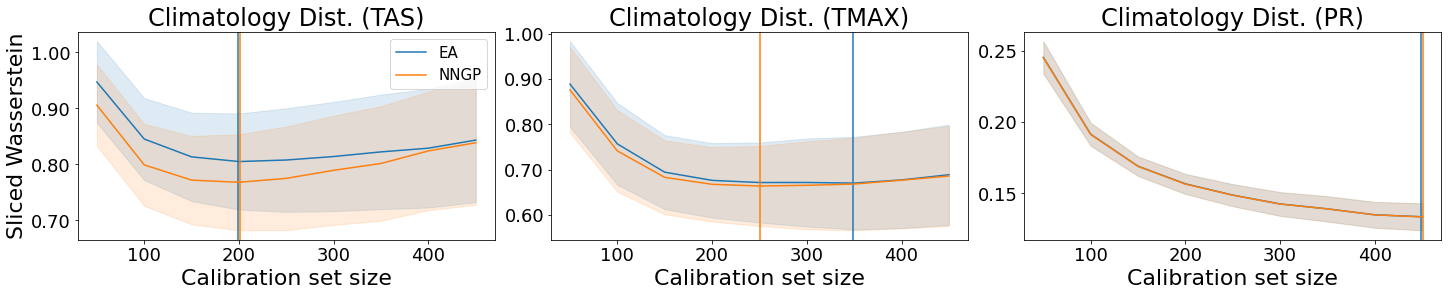

In [27]:
fig = plt.figure(constrained_layout = True, figsize = (20, 4))
gs = GridSpec(1, 3, figure = fig)

mu = [tas_mu, tmax_mu, pr_mu]
se = [tas_sd, tmax_sd, pr_sd]
nvals = np.arange(50, 500, 50)
climvars = ['TAS', 'TMAX', 'PR']

ax = plt.subplot(gs[0])
ax.plot([], [], c = 'C0', label = 'EA')
ax.plot([], [], c = 'C1', label = 'NNGP')
ax.legend(loc = 'upper right', fontsize = 15)
    
for i in range(3):
    ax = plt.subplot(gs[i])
    ax.set_title(f'Climatology Dist. ({climvars[i]})', fontsize = 24)
    ax.set_xlabel('Calibration set size', fontsize = 22)
    if i == 0: ax.set_ylabel('Sliced Wasserstein', fontsize = 22)
    ax.yaxis.set_major_formatter('{x:0<3.2f}')
    ax.yaxis.set_tick_params(labelsize=18)
    ax.xaxis.set_tick_params(labelsize=18)
    
    mean_ea = mu[i][0]
    ste_ea = se[i][0]
    lower_ea = mean_ea - 2 * ste_ea
    upper_ea = mean_ea + 2 * ste_ea
    
    mean_gp = mu[i][1]
    ste_gp = se[i][0]
    lower_gp = mean_gp - 2 * ste_gp
    upper_gp = mean_gp + 2 * ste_gp

    ax.fill_between(nvals, lower_ea, upper_ea, alpha = 0.14, color = 'C0')
    ax.plot(nvals, mean_ea, c = 'C0')
    ax.axvline(nvals[np.argmin(mean_ea)]-1, c = 'C0')
    
    ax.fill_between(nvals, lower_gp, upper_gp, alpha = 0.14, color = 'C1')
    ax.plot(nvals, mean_gp, c = 'C1')
    ax.axvline(nvals[np.argmin(mean_gp)]+1, c = 'C1')
#     ax.set_xticks(s, years, fontsize = 16, rotation=45)

In [60]:
analysis = ['ens', 'wa', 'delta', 'lm', 'nngp', 'cnn1']
nproj = len(analysis)
tas_results = np.zeros((nmod, nproj, 5, 3, 2))
w = slices(nlat, nlon)

for model_no in trange(nmod):
    xtrain_anom, xtest_anom = anomalize(xtrain_orig, xtest_orig, model_no)
    _data = scale_and_split(xtrain_anom, xtest_anom, model_no = model_no, nval = nval)
    
    xtrain_scaled = _data[0]
    xval_scaled = _data[1]
    xtest_scaled = _data[2]
    ytrain_scaled = _data[3]
    yval_scaled = _data[4]
    xtrain_mean = _data[5]
    xtest_mean = _data[6]
    xtrain_sd = _data[7]
    xtest_sd = _data[8]

    ntrain = xtrain_scaled.shape[0]
    nval = xval_scaled.shape[0]
    ntest = xtest_scaled.shape[0]

    del _data

    weight = jnp.cos(jnp.linspace(math.pi/2 - 1/nlat, -math.pi/2 + 1/nlat, nlat))
    weight = weight / jnp.mean(weight)
    weight = weight[None,:,None]
    
    for k in trange(0, nproj, leave = False):
        xval = xtrain_sd[-nval:,None] * xval_scaled + xtrain_mean[-nval:,None]
        yval = xtrain_sd[-nval:] * yval_scaled + xtrain_mean[-nval:]
        yval_hat = np.load(save_loc + f'/yval_{analysis[k]}_{model_no}.npy')
        yval_hat = yval_hat.reshape(-1, nlat, nlon)

        if analysis[k] == 'lm':
            yval_hat = np.clip(yval_hat, -3, 3)

        yval1 = yval[:100]
        yval2 = yval[100:]
        yval_hat1 = yval_hat[:100]
        yval_hat2 = yval_hat[100:]
        resval1 = yval1 - yval_hat1
        resval2 = yval2 - yval_hat2

        imv_ens = xval[100:]
        imv_ens = imv_ens - yval_hat2[:,None]

        ytrain_qc = xtrain_sd[:-nval] * ytrain_scaled + xtrain_mean[:-nval]
        xtrain_qc = xtrain_sd[:-nval,None] * xtrain_scaled + xtrain_mean[:-nval,None]
        qc_ens = jnp.array([quantile_map(ytrain_qc, xtrain_qc[:100,j], xval[100:,j], 20) for j in range(nmod)])
        qc_ens = np.moveaxis(qc_ens, 0, 1)
        qc_ens = qc_ens - yval_hat2[:,None]

        depth_fns = [global_mmd_self, tukey_depth_self, inf_depth]
        conf_ens1 = conformal_ensemble(resval1, depth_fns[0], 0.1)
        conf_ens2 = conformal_ensemble(resval1, depth_fns[1], 0.1)
        conf_ens3 = conformal_ensemble(resval1, depth_fns[2], 0.1)

        for i, p in enumerate(period):
            tas_results[model_no, k, 0, 0, i] = sw2(imv_ens, resval2[p[0]:p[1]], w)
            tas_results[model_no, k, 1, 0, i] = sw2(qc_ens, resval2[p[0]:p[1]], w)
            tas_results[model_no, k, 2, 0, i] = sw2(conf_ens1, resval2[p[0]:p[1]], w)
            tas_results[model_no, k, 3, 0, i] = sw2(conf_ens2, resval2[p[0]:p[1]], w)
            tas_results[model_no, k, 4, 0, i] = sw2(conf_ens3, resval2[p[0]:p[1]], w)
            tas_results[model_no, k, 0, 1, i] = np.median(single_ens_crps(imv_ens[p[0]:p[1]].reshape(-1, nlat, nlon), resval2[p[0]:p[1]]) * weight)
            tas_results[model_no, k, 1, 1, i] = np.median(single_ens_crps(qc_ens[p[0]:p[1]].reshape(-1, nlat, nlon), resval2[p[0]:p[1]]) * weight)
            tas_results[model_no, k, 2, 1, i] = np.median(single_ens_crps(shuffle(conf_ens1)[0:90], resval2[p[0]:p[1]]) * weight)
            tas_results[model_no, k, 3, 1, i] = np.median(single_ens_crps(shuffle(conf_ens2)[0:90], resval2[p[0]:p[1]]) * weight)
            tas_results[model_no, k, 4, 1, i] = np.median(single_ens_crps(shuffle(conf_ens3)[0:90], resval2[p[0]:p[1]]) * weight)
            tas_results[model_no, k, 0, 2, i] = np.median(pit(imv_ens[p[0]:p[1]].reshape(-1, nlat, nlon), resval2[p[0]:p[1]]) * weight)
            tas_results[model_no, k, 1, 2, i] = np.median(pit(qc_ens[p[0]:p[1]].reshape(-1, nlat, nlon), resval2[p[0]:p[1]]) * weight)
            tas_results[model_no, k, 2, 2, i] = np.median(pit(shuffle(conf_ens1)[0:90], resval2[p[0]:p[1]]) * weight)
            tas_results[model_no, k, 3, 2, i] = np.median(pit(shuffle(conf_ens2)[0:90], resval2[p[0]:p[1]]) * weight)
            tas_results[model_no, k, 4, 2, i] = np.median(pit(shuffle(conf_ens3)[0:90], resval2[p[0]:p[1]]) * weight)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/1008 [00:00<?, ?it/s]

  0%|          | 0/912 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

TypeError: Slice size at index 0 in gather op is out of range, must be within [0, 0 + 1), got 1.

In [63]:
resval2.shape

(100, 90, 180)

In [61]:
 resval2[p[0]:p[1]]

Array([], dtype=float64)

In [49]:
# analysis = ['ens', 'wa', 'delta', 'lm', 'nngp', 'cnn1']
# pr_results = np.zeros([nmod, nproj, 5])

# np.random.seed(0)
# w = np.random.normal(0,1, [500, nlat*nlon])
# w = w / np.sqrt(np.sum(w**2, axis = 1))[:,None]

# for model_no in trange(nmod):
#     xtrain, xval, xtest, ytrain, yval, ytest, xtrain_sd, xtest_sd = scale_and_split(xtrain_orig, xtest_orig, model_no = model_no, nval = nval)

#     xval = xval * xtrain_sd[-nval:,None]
#     xval = xval - np.mean(xval, axis = 1)[:,None]
#     xtest = xtest * xtest_sd[:,None]
#     imv_ens = xtest - np.mean(xtest, axis = 1)[:,None]

#     xtest_qc = jnp.array([quantile_map(yval, xval[:,j], xtest[:,j], 20) for j in trange(1, nmod, leave = False)])
#     xtest_qc = np.moveaxis(xtest_qc, 0, 1)
#     qc_ens = xtest_qc - np.mean(xtest_qc, axis = 1)[:,None]
    
#     ytest = ytest * xtest_sd
#     yval = yval * xtrain_sd[-nval:]
    
#     for k in range(0, nproj):
        
#         yval_hat = np.load(save_loc + f'/yval_{analysis[k]}_{model_no}.npy')
#         ytest_hat = np.load(save_loc + f'/ytest_{analysis[k]}_{model_no}.npy')
        
#         if analysis[k] == 'lm':
#             yval_hat = np.clip(yval_hat, -3, 3)
#             ytest_hat = np.clip(ytest_hat, -3, 3)
            
#         yval_hat = yval_hat.reshape(-1, nlat, nlon)
#         ytest_hat = ytest_hat.reshape(-1, nlat, nlon)
        
#         yval_hat = yval_hat * xtrain_sd[-nval:]
#         ytest_hat = ytest_hat * xtest_sd
#         resval = (yval - yval_hat).reshape(-1, nlat, nlon)
#         restest = (ytest - ytest_hat).reshape(-1, nlat, nlon)
        
#         alpha = 0.1
#         level = np.ceil((1 - alpha) * (nval + 1))/(nval + 1)
#         dr1 = 1 - global_mmd_self(resval, resval)
#         q = np.sort(dr1)[int(np.ceil((1 - alpha) * (nval + 1)))]
#         q = (q + np.quantile(dr1, level))/2
#         conf_ens1 = resval[dr1 < q]
        
#         dr1 = 1 - tukey_depth_self(resval, resval)
#         q = np.sort(dr1)[int(np.ceil((1 - alpha) * (nval + 1)))]
#         q = (q + np.quantile(dr1, level))/2
#         conf_ens2 = resval[dr1 < q]
        
#         dr1 = 1 - inf_depth(resval)
#         q = np.sort(dr1)[int(np.ceil((1 - alpha) * (nval + 1)))]
#         q = (q + np.quantile(dr1, level))/2
#         conf_ens3 = resval[dr1 < q]
        
#         pr_results[model_no, k, 0] = sw2(imv_ens, restest, w)
#         pr_results[model_no, k, 1] = sw2(qc_ens, restest, w)
#         pr_results[model_no, k, 2] = sw2(conf_ens1, restest, w)
#         pr_results[model_no, k, 3] = sw2(conf_ens2, restest, w)
#         pr_results[model_no, k, 4] = sw2(conf_ens3, restest, w)

In [179]:
np.round(np.mean(pr_results, axis = 0), 3)

array([[1.006, 0.638, 0.161, 0.162, 0.159],
       [0.797, 0.325, 0.17 , 0.171, 0.169],
       [0.816, 0.368, 0.17 , 0.172, 0.169],
       [0.833, 0.732, 0.222, 0.225, 0.221],
       [0.804, 0.306, 0.165, 0.165, 0.163],
       [0.843, 0.34 , 0.172, 0.172, 0.17 ]])

In [180]:
np.round(np.std(pr_results, axis = 0) / np.sqrt(nmod), 3)

array([[0.125, 0.196, 0.004, 0.004, 0.003],
       [0.011, 0.081, 0.007, 0.008, 0.007],
       [0.026, 0.072, 0.008, 0.008, 0.008],
       [0.103, 0.142, 0.004, 0.005, 0.004],
       [0.011, 0.093, 0.007, 0.007, 0.007],
       [0.044, 0.064, 0.012, 0.012, 0.012]])

In [181]:
results = [tas_results, tmax_results, pr_results]

In [182]:
results_mu = [np.median(z, axis = 0) for z in results]
results_se = [np.std(z, axis = 0)/np.sqrt(nmod) for z in results]

results_mu = np.stack(results_mu)
results_se = np.stack(results_se)

In [183]:
results_mu

array([[[2.34249198, 2.44311713, 0.77542889, 0.75148356, 0.76327584],
        [1.79868137, 1.31542901, 0.693855  , 0.69984469, 0.68504931],
        [1.74086697, 1.69490721, 0.79041416, 0.78762158, 0.76964498],
        [2.49220266, 4.22517738, 1.28624283, 1.32798416, 1.33152947],
        [1.82860889, 1.33355276, 0.71668086, 0.7037743 , 0.70944306],
        [1.70688683, 1.44971722, 0.66448753, 0.66017411, 0.66381354]],

       [[2.9258626 , 2.33224803, 0.65434669, 0.67925635, 0.64501332],
        [2.38829153, 1.42643433, 0.63188461, 0.62800951, 0.62218883],
        [2.26931067, 1.59347018, 0.64298247, 0.64520065, 0.63821919],
        [2.43920686, 3.96465946, 1.17704492, 1.18632615, 1.17277761],
        [2.44461006, 1.36540458, 0.59433795, 0.58893179, 0.59866877],
        [2.30639967, 1.50230374, 0.58505129, 0.58802939, 0.56755603]],

       [[0.86719269, 0.45333581, 0.16048045, 0.16239216, 0.16086216],
        [0.79707927, 0.24167416, 0.16224743, 0.16411379, 0.16005524],
        [0.79724

In [184]:
z_mu.shape

(5, 6)

In [185]:
# analysis = ['EA', 'WA', 'Delta', 'LM', 'GP', 'CNN']
uq_method = ['IMV', 'IMV (BC)', 'CE ($\ell_\infty$)', 'CE (Tukey)', 'CE (Norm)']
for i in range(3):
    z_mu = results_mu[i].T
    z_se = results_se[i].T
    for j, _ in enumerate(z_mu):
        x_mu = [f"{k:1.3f}" for k in z_mu[j]]
        x_se = [f"{k:1.3f}" for k in z_se[j]]
    
        print(f'{uq_method[j]}', end=' & ')
        for k in range(6):
            print(f'{x_mu[k]} ({x_se[k]})', end=' & ')
        print('\b\b \\\\')
        
    print('\\midrule')

IMV & 2.342 (0.061) & 1.799 (0.029) & 1.741 (0.040) & 2.492 (0.059) & 1.829 (0.028) & 1.707 (0.022) &  \\
IMV (BC) & 2.443 (0.087) & 1.315 (0.055) & 1.695 (0.065) & 4.225 (0.067) & 1.334 (0.065) & 1.450 (0.047) &  \\
CE ($\ell_\infty$) & 0.775 (0.041) & 0.694 (0.040) & 0.790 (0.044) & 1.286 (0.031) & 0.717 (0.041) & 0.664 (0.043) &  \\
CE (Tukey) & 0.751 (0.040) & 0.700 (0.037) & 0.788 (0.044) & 1.328 (0.030) & 0.704 (0.040) & 0.660 (0.042) &  \\
CE (Norm) & 0.763 (0.040) & 0.685 (0.040) & 0.770 (0.045) & 1.332 (0.030) & 0.709 (0.042) & 0.664 (0.043) &  \\
\midrule
IMV & 2.926 (0.183) & 2.388 (0.013) & 2.269 (0.015) & 2.439 (0.154) & 2.445 (0.012) & 2.306 (0.019) &  \\
IMV (BC) & 2.332 (0.235) & 1.426 (0.060) & 1.593 (0.065) & 3.965 (0.162) & 1.365 (0.055) & 1.502 (0.070) &  \\
CE ($\ell_\infty$) & 0.654 (0.039) & 0.632 (0.039) & 0.643 (0.040) & 1.177 (0.039) & 0.594 (0.038) & 0.585 (0.040) &  \\
CE (Tukey) & 0.679 (0.032) & 0.628 (0.037) & 0.645 (0.031) & 1.186 (0.037)

In [92]:
f'{x_mu[k]} ({x_se[k]})'

'0.160 (0.012)'

In [93]:
for k in range(6):
    print(f'{x_mu[k]} ({x_se[k]})')

0.160 (0.004)
0.162 (0.007)
0.162 (0.008)
0.218 (0.004)
0.157 (0.007)
0.160 (0.012)


## Temperature (TAS)

In [97]:
nproj = 6
nval = 200

xhist_tas = pickle.load(open('../data/xhist_tas_hr.pkl', 'rb'))
xrcp_tas = pickle.load(open('../data/xrcp_tas_hr.pkl', 'rb'))
nmod = xhist_tas.shape[1]
nlat, nlon = xhist_tas[0].shape[1:]

n = (2015 - 1940) * 12
xhist_tas = xhist_tas[-n:]

xtrain_orig = np.concatenate([xhist_tas, xrcp_tas[:108]], axis = 0)
xtest_orig = xrcp_tas[108:]

ntrain = xtrain_orig.shape[0] - nval
ntest = xtest_orig.shape[0]

save_loc = 'trained_models/tas'

# level = 1 - np.ceil((1-0.1) * (nval + 1))/(nval + 1)
alpha = 0.1
level = 1 - np.ceil((1 - alpha) * (nval + 1))/(nval + 1)

In [99]:
# [metrics(imv_ens, restest), sw2(imv_ens.reshape(-1,nlat,nlon), restest, w)]

In [101]:
analysis = ['ens', 'wa', 'delta', 'lm', 'nngp', 'cnn1']
results = np.zeros([nmod, 2 * nproj, 4])

np.random.seed(0)
w = np.random.normal(0,1, [500, nlat*nlon])
w = w / np.sqrt(np.sum(w**2, axis = 1))[:,None]

for model_no in trange(nmod):
    xtrain, xval, xtest, ytrain, yval, ytest = scale_and_split(xtrain_orig, xtest_orig, model_no = model_no, nval = nval)
    
    for k in range(0, 2 * nproj, 2):
        
        yval_hat = np.load(save_loc + f'/yval_{analysis[k//2]}_{model_no}.npy')
        ytest_hat = np.load(save_loc + f'/ytest_{analysis[k//2]}_{model_no}.npy')
        
        if analysis[k//2] == 'lm':
            yval_hat = np.clip(yval_hat, -3, 3)
            ytest_hat = np.clip(ytest_hat, -3, 3)
        
        resval = yval - yval_hat.reshape(yval.shape)
        restest = ytest - ytest_hat.reshape(ytest.shape)
        dr1 = global_mmd_self(resval, resval)
        q = np.quantile(dr1, level)

        ## IMV
        imv_ens = np.delete(xtest_orig, model_no, 1)
        imv_ens = imv_ens - np.mean(imv_ens, axis = 1)[:,None,:,:]
        results[model_no, k, :-1] = metrics(imv_ens, restest)
        results[model_no, k, -1] = sw2(imv_ens.reshape(-1,nlat,nlon), restest, w)

        ## conformal
        conf_ens = resval[dr1 > q]
        results[model_no, k+1, :-1] = metrics(conf_ens, restest)
        results[model_no, k+1, -1] = sw2(conf_ens, restest, w)

  0%|          | 0/31 [00:00<?, ?it/s]

In [102]:
tas_results = results

In [103]:
np.set_printoptions(precision=3, floatmode = 'fixed')
table = np.mean(tas_results, axis = 0)[:,1:]

analysis = ['EA', 'WA', 'Del', 'LM', 'GP', 'CNN']
for i, row in enumerate(table):
    x = [f"{i:1.3f}" for i in row]
    print(analysis[i//2], '\t', ' & '.join(x))

EA 	 0.682 & 0.059 & 4.013
EA 	 0.380 & 0.015 & 0.246
WA 	 0.539 & 0.032 & 4.010
WA 	 0.353 & 0.016 & 0.242
Del 	 0.561 & 0.031 & 3.949
Del 	 0.380 & 0.015 & 0.246
LM 	 0.882 & 0.042 & 3.429
LM 	 0.632 & 0.014 & 0.423
GP 	 0.526 & 0.033 & 4.044
GP 	 0.337 & 0.018 & 0.236
CNN 	 0.541 & 0.029 & 3.985
CNN 	 0.360 & 0.011 & 0.215


## Temperature Max (TMAX)

In [104]:
nproj = 6
nval = 200

xhist_tas = pickle.load(open('../data/xhist_tasmax_hr.pkl', 'rb'))
xrcp_tas = pickle.load(open('../data/xrcp_tasmax_hr.pkl', 'rb'))
nmod = xhist_tas.shape[1]

n = (2015 - 1940) * 12
xhist_tas = xhist_tas[-n:]

xtrain_orig = np.concatenate([xhist_tas, xrcp_tas[:108]], axis = 0)
xtest_orig = xrcp_tas[108:]

ntrain = xtrain_orig.shape[0] - nval
ntest = xtest_orig.shape[0]

save_loc = 'trained_models/tmax'

level = 1 - np.ceil((1-0.1) * (nval + 1))/(nval + 1)

In [105]:
analysis = ['ens', 'wa', 'delta', 'lm', 'nngp', 'cnn1']
results = np.zeros([nmod, 2 * nproj, 4])

np.random.seed(0)
w = np.random.normal(0,1, [500, nlat*nlon])
w = w / np.sqrt(np.sum(w**2, axis = 1))[:,None]

for model_no in trange(nmod):
    xtrain, xval, xtest, ytrain, yval, ytest = scale_and_split(xtrain_orig, xtest_orig, model_no = model_no, nval = nval)
    
    for k in range(0, 2 * nproj, 2):
        
        yval_hat = np.load(save_loc + f'/yval_{analysis[k//2]}_{model_no}.npy')
        ytest_hat = np.load(save_loc + f'/ytest_{analysis[k//2]}_{model_no}.npy')
        
        if analysis[k//2] == 'lm':
            yval_hat = np.clip(yval_hat, -3, 3)
            ytest_hat = np.clip(ytest_hat, -3, 3)
        
        resval = yval - yval_hat.reshape(yval.shape)
        restest = ytest - ytest_hat.reshape(ytest.shape)
        dr1 = global_mmd_self(resval, resval)
        q = np.quantile(dr1, level)
        
        ## IMV
        imv_ens = np.delete(xtest_orig, model_no, 1)[:,1:]
        imv_ens = imv_ens - np.mean(imv_ens, axis = 1)[:,None,:,:]
        results[model_no, k, :-1] = metrics(imv_ens, restest)
        results[model_no, k, -1] = sw2(imv_ens.reshape(-1,nlat,nlon), restest, w)

        ## conformal
        conf_ens = resval[dr1 > q]
        results[model_no, k+1, :-1] = metrics(conf_ens, restest)
        results[model_no, k+1, -1] = sw2(conf_ens, restest, w)
    

  0%|          | 0/20 [00:00<?, ?it/s]

In [106]:
tmax_results = results

## Precipitation (PR)

In [107]:
nproj = 6
nval = 200

xhist_tas = pickle.load(open('../data/xhist_pr_hr.pkl', 'rb'))
xrcp_tas = pickle.load(open('../data/xrcp_pr_hr.pkl', 'rb'))
nmod = xhist_tas.shape[1]

n = (2015 - 1940) * 12
xhist_tas = xhist_tas[-n:]

xtrain_orig = np.concatenate([xhist_tas, xrcp_tas[:108]], axis = 0)
xtest_orig = xrcp_tas[108:]

ntrain = xtrain_orig.shape[0] - nval
ntest = xtest_orig.shape[0]

xtrain_orig = np.log(np.abs(xtrain_orig) + 1e-3)
xtest_orig = np.log(np.abs(xtest_orig) + 1e-3)

save_loc = 'trained_models/pr'

level = 1 - np.ceil((1-0.1) * (nval + 1))/(nval + 1)

In [108]:
analysis = ['ens', 'wa', 'delta', 'lm', 'nngp', 'cnn1']
results = np.zeros([nmod, 2 * nproj, 4])

for model_no in trange(nmod):
    xtrain, xval, xtest, ytrain, yval, ytest = scale_and_split(xtrain_orig, xtest_orig, model_no = model_no, nval = nval)
    
    for k in range(0, 2 * nproj, 2):
        
        yval_hat = np.load(save_loc + f'/yval_{analysis[k//2]}_{model_no}.npy')
        ytest_hat = np.load(save_loc + f'/ytest_{analysis[k//2]}_{model_no}.npy')
        
        if analysis[k//2] == 'lm':
            yval_hat = np.clip(yval_hat, -3, 3)
            ytest_hat = np.clip(ytest_hat, -3, 3)
        
        resval = yval - yval_hat.reshape(yval.shape)
        restest = ytest - ytest_hat.reshape(ytest.shape)
        dr1 = global_mmd_self(resval, resval)
        q = np.quantile(dr1, level)

        ## IMV
        imv_ens = np.delete(xtest_orig, model_no, 1)[:,1:]
        imv_ens = imv_ens - np.mean(imv_ens, axis = 1)[:,None,:,:]
        results[model_no, k, :-1] = metrics(imv_ens, restest)
        results[model_no, k, -1] = sw2(imv_ens.reshape(-1,nlat,nlon), restest, w)

        ## conformal
        conf_ens = resval[dr1 > q]
        results[model_no, k+1, :-1] = metrics(conf_ens, restest)
        results[model_no, k+1, -1] = sw2(conf_ens, restest, w)
    

  0%|          | 0/30 [00:00<?, ?it/s]

In [109]:
pr_results = results

In [110]:
tas_results2 = np.mean(tas_results, axis = 0)[:,1:]
tmax_results2 = np.mean(tmax_results, axis = 0)[:,1:]
pr_results2 = np.mean(pr_results, axis = 0)[:,1:]

table = np.stack([tas_results2, tmax_results2, pr_results2], axis = 0)
table[:,:,0].T

array([[0.682, 0.732, 0.667],
       [0.380, 0.368, 0.330],
       [0.539, 0.564, 0.373],
       [0.353, 0.339, 0.305],
       [0.561, 0.585, 0.405],
       [0.380, 0.368, 0.330],
       [0.882, 0.859, 0.688],
       [0.632, 0.555, 0.389],
       [0.526, 0.551, 0.355],
       [0.337, 0.323, 0.286],
       [0.541, 0.572, 0.403],
       [0.360, 0.349, 0.320]])

In [111]:
tas_results2 = np.mean(tas_results, axis = 0)[:,1:]
tmax_results2 = np.mean(tmax_results, axis = 0)[:,1:]
pr_results2 = np.mean(pr_results, axis = 0)[:,1:]

table = np.stack([tas_results2, tmax_results2, pr_results2], axis = 0)
table = np.moveaxis(table, (1, 2), (0, 1)).reshape(12, -1)
table.shape

(12, 9)

In [112]:
analysis = ['EA', 'WA', 'Delta', 'LM', 'GP', 'CNN']
for i, row in enumerate(table):
    x = [f"{i:1.3f}" for i in row]
    print(analysis[i//2], '\t & ', ' & '.join(x))

EA 	 &  0.682 & 0.732 & 0.667 & 0.059 & 0.062 & 0.027 & 4.013 & 4.325 & 1.481
EA 	 &  0.380 & 0.368 & 0.330 & 0.015 & 0.014 & 0.002 & 0.246 & 0.237 & 0.125
WA 	 &  0.539 & 0.564 & 0.373 & 0.032 & 0.035 & 0.032 & 4.010 & 4.281 & 1.129
WA 	 &  0.353 & 0.339 & 0.305 & 0.016 & 0.016 & 0.002 & 0.242 & 0.236 & 0.126
Delta 	 &  0.561 & 0.585 & 0.405 & 0.031 & 0.034 & 0.036 & 3.949 & 4.224 & 1.134
Delta 	 &  0.380 & 0.368 & 0.330 & 0.015 & 0.014 & 0.002 & 0.246 & 0.237 & 0.125
LM 	 &  0.882 & 0.859 & 0.688 & 0.042 & 0.050 & 0.038 & 3.429 & 3.852 & 1.275
LM 	 &  0.632 & 0.555 & 0.389 & 0.014 & 0.014 & 0.002 & 0.423 & 0.387 & 0.165
GP 	 &  0.526 & 0.551 & 0.355 & 0.033 & 0.036 & 0.033 & 4.044 & 4.311 & 1.126
GP 	 &  0.337 & 0.323 & 0.286 & 0.018 & 0.018 & 0.002 & 0.236 & 0.233 & 0.121
CNN 	 &  0.541 & 0.572 & 0.403 & 0.029 & 0.033 & 0.033 & 3.985 & 4.255 & 1.165
CNN 	 &  0.360 & 0.349 & 0.320 & 0.011 & 0.010 & 0.002 & 0.215 & 0.209 & 0.127


# Seasonal results

In [12]:
nproj = 6
nval = 200

xhist_tas = pickle.load(open('../data/xhist_tas_hr.pkl', 'rb'))
xrcp_tas = pickle.load(open('../data/xrcp_tas_hr.pkl', 'rb'))
nmod = xhist_tas.shape[1]

n = (2015 - 1940) * 12
xhist_tas = xhist_tas[-n:]
nlat, nlon = xhist_tas[0].shape[1:]

xtrain_orig = np.concatenate([xhist_tas, xrcp_tas[:72]], axis = 0)
xtest_orig = xrcp_tas[72:]

ntrain = xtrain_orig.shape[0] - nval
ntest = xtest_orig.shape[0]

save_loc = 'trained_models/tas'

alpha = 0.1
level = 1 - np.ceil((1 - alpha) * (nval + 1))/(nval + 1)

In [20]:
analysis = ['ens', 'wa', 'delta', 'lm', 'nngp', 'cnn1']
results = np.zeros([nmod, 2 * nproj, 3])

model_no = 0
k = 0

xtrain, xval, xtest, ytrain, yval, ytest = scale_and_split(xtrain_orig, xtest_orig, model_no = model_no, nval = nval)
    
yval_hat = np.load(save_loc + f'/yval_{analysis[k//2]}_{model_no}.npy')
ytest_hat = np.load(save_loc + f'/ytest_{analysis[k//2]}_{model_no}.npy')

if analysis[k//2] == 'lm':
    yval_hat = np.clip(yval_hat, -3, 3)
    ytest_hat = np.clip(ytest_hat, -3, 3)

resval = yval - yval_hat.reshape(yval.shape)
restest = ytest - ytest_hat.reshape(ytest.shape)
dr1 = inf_depth(resval)
q = np.quantile(dr1, level)

## IMV
imv_ens = np.delete(xtest_orig, model_no, 1)
imv_ens = imv_ens - np.mean(imv_ens, axis = 1)[:,None,:,:]
# results[model_no, k] = metrics(imv_ens, restest)

# ## conformal
conf_ens = resval[dr1 > q]
# results[model_no, k+1] = metrics(conf_ens, restest)

In [24]:
analysis = ['ens', 'wa', 'delta', 'lm', 'nngp', 'cnn1']
results = np.zeros([nmod, 2 * nproj, 12, 3])

for model_no in trange(nmod):
    xtrain, xval, xtest, ytrain, yval, ytest = scale_and_split(xtrain_orig, xtest_orig, model_no = model_no, nval = nval)
    
    for k in range(0, 2 * nproj, 2):
        
        yval_hat = np.load(save_loc + f'/yval_{analysis[k//2]}_{model_no}.npy')
        ytest_hat = np.load(save_loc + f'/ytest_{analysis[k//2]}_{model_no}.npy')
        
        if analysis[k//2] == 'lm':
            yval_hat = np.clip(yval_hat, -3, 3)
            ytest_hat = np.clip(ytest_hat, -3, 3)
        
        resval = yval - yval_hat.reshape(yval.shape)
        restest = ytest - ytest_hat.reshape(ytest.shape)
        dr1 = inf_depth(resval)
        q = np.quantile(dr1, level)

        ## IMV
        imv_ens = np.delete(xtest_orig, model_no, 1)
        imv_ens = imv_ens - np.mean(imv_ens, axis = 1)[:,None,:,:]
        results[model_no, k] = np.array([metrics(imv_ens[i::12], restest[i::12]) for i in range(12)])

        ## conformal
        conf_ens = resval[dr1 > q]
        results[model_no, k+1] = np.array([metrics(conf_ens, restest[i::12]) for i in range(12)])
    

  0%|          | 0/31 [00:00<?, ?it/s]

In [68]:
adj_results = np.zeros_like(results)
adj_results[:,:,1:,:] = results[:,:,:-1,:]
adj_results[:,:,0,:] = results[:,:,-1,:]

In [78]:
np.round(np.mean(np.mean(adj_results[:,:,:,1], axis = 0).reshape(12, 3, 4), axis = 1), 2)

array([[0.66, 0.66, 0.66, 0.66],
       [0.39, 0.39, 0.39, 0.39],
       [0.52, 0.51, 0.51, 0.51],
       [0.36, 0.36, 0.37, 0.36],
       [0.54, 0.54, 0.53, 0.53],
       [0.39, 0.39, 0.39, 0.39],
       [0.88, 0.88, 0.88, 0.88],
       [0.66, 0.67, 0.67, 0.67],
       [0.5 , 0.5 , 0.5 , 0.5 ],
       [0.34, 0.34, 0.35, 0.35],
       [0.52, 0.52, 0.51, 0.51],
       [0.37, 0.37, 0.37, 0.37]])

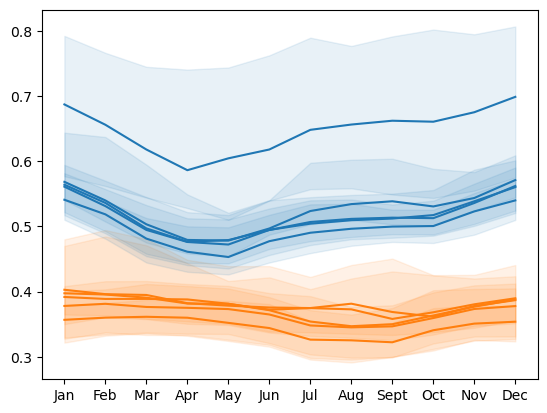

In [88]:
analysis = ['ens', 'wa', 'delta', 'lm', 'nngp', 'cnn1']
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
s = np.arange(12)
for k in range(0, 2*nproj, 2):
    
    mean_imv = np.median(results[:,k,:,1], axis = 0)
    lower_imv = np.quantile(results[:,k,:,1], 0.1, axis = 0)
    upper_imv = np.quantile(results[:,k,:,1], 0.9, axis = 0)

    mean_conf = np.median(results[:,k+1,:,1], axis = 0)
    lower_conf = np.quantile(results[:,k+1,:,1], 0.1, axis = 0)
    upper_conf = np.quantile(results[:,k+1,:,1], 0.9, axis = 0)

    if analysis[k//2] != 'lm':
        plt.fill_between(s, lower_imv, upper_imv, alpha = 0.1, color = 'C0')
        plt.plot(mean_imv.T, c = 'C0')
        plt.xticks(s, months)

        plt.fill_between(s, lower_conf, upper_conf, alpha = 0.1, color = 'C1')
        plt.plot(mean_conf.T, c = 'C1')
#         plt.xticks(s, months)

plt.show()

In [13]:
nproj = 6
nval = 200

xhist_tas = pickle.load(open('../data/xhist_tas_hr.pkl', 'rb'))
xrcp_tas = pickle.load(open('../data/xrcp_tas_hr.pkl', 'rb'))
nmod = xhist_tas.shape[1]

n = (2015 - 1940) * 12
xhist_tas = xhist_tas[-n:]
nlat, nlon = xhist_tas[0].shape[1:]

xtrain_orig = np.concatenate([xhist_tas, xrcp_tas[:108]], axis = 0)
xtest_orig = xrcp_tas[108:]

ntrain = xtrain_orig.shape[0] - nval
ntest = xtest_orig.shape[0]

save_loc = 'trained_models/tas'

alpha = 0.1
level = 1 - np.ceil((1 - alpha) * (nval + 1))/(nval + 1)

In [14]:
np.random.seed(0)
w = np.random.normal(0,1, [500, nlat*nlon])
w = w / np.sqrt(np.sum(w**2, axis = 1))[:,None]

In [15]:
analysis = ['ens', 'wa', 'delta', 'lm', 'nngp', 'cnn1']
tas_results = np.zeros([nmod, 2 * nproj, 12, 4])

for model_no in trange(nmod):
    xtrain, xval, xtest, ytrain, yval, ytest = scale_and_split(xtrain_orig, xtest_orig, model_no = model_no, nval = nval)
    
    for k in range(0, 2 * nproj, 2):
        
        yval_hat = np.load(save_loc + f'/yval_{analysis[k//2]}_{model_no}.npy')
        ytest_hat = np.load(save_loc + f'/ytest_{analysis[k//2]}_{model_no}.npy')
        
        if analysis[k//2] == 'lm':
            yval_hat = np.clip(yval_hat, -3, 3)
            ytest_hat = np.clip(ytest_hat, -3, 3)
        
        resval = yval - yval_hat.reshape(yval.shape)
        restest = ytest - ytest_hat.reshape(ytest.shape)
        dr1 = inf_depth(resval)
        q = np.quantile(dr1, level)

        ## IMV
        imv_ens = np.delete(xtest_orig, model_no, 1)
        imv_ens = imv_ens - np.mean(imv_ens, axis = 1)[:,None,:,:]
        tas_results[model_no, k, :, :-1] = np.array([metrics(imv_ens[i::12], restest[i::12]) for i in range(12)])
        tas_results[model_no, k, :, -1] = np.array([sw2(imv_ens[i::12], restest[i::12], w) for i in range(12)])

        ## conformal
        conf_ens = resval[dr1 > q]
        tas_results[model_no, k+1, :, :-1] = np.array([metrics(conf_ens, restest[i::12]) for i in range(12)])
        tas_results[model_no, k+1, :, -1] = np.array([sw2(conf_ens, restest[i::12], w) for i in range(12)])
    

  0%|          | 0/31 [00:00<?, ?it/s]

In [16]:
nproj = 6
nval = 200

xhist_tas = pickle.load(open('../data/xhist_tasmax_hr.pkl', 'rb'))
xrcp_tas = pickle.load(open('../data/xrcp_tasmax_hr.pkl', 'rb'))
nmod = xhist_tas.shape[1]

n = (2015 - 1940) * 12
xhist_tas = xhist_tas[-n:]

xtrain_orig = np.concatenate([xhist_tas, xrcp_tas[:108]], axis = 0)
xtest_orig = xrcp_tas[108:]

ntrain = xtrain_orig.shape[0] - nval
ntest = xtest_orig.shape[0]

save_loc = 'trained_models/tmax'

alpha = 0.1
level = 1 - np.ceil((1 - alpha) * (nval + 1))/(nval + 1)

In [17]:
analysis = ['ens', 'wa', 'delta', 'lm', 'nngp', 'cnn1']
tmax_results = np.zeros([nmod, 2 * nproj, 12, 4])

for model_no in trange(nmod):
    xtrain, xval, xtest, ytrain, yval, ytest = scale_and_split(xtrain_orig, xtest_orig, model_no = model_no, nval = nval)
    
    for k in range(0, 2 * nproj, 2):
        
        yval_hat = np.load(save_loc + f'/yval_{analysis[k//2]}_{model_no}.npy')
        ytest_hat = np.load(save_loc + f'/ytest_{analysis[k//2]}_{model_no}.npy')
        
        if analysis[k//2] == 'lm':
            yval_hat = np.clip(yval_hat, -3, 3)
            ytest_hat = np.clip(ytest_hat, -3, 3)
        
        resval = yval - yval_hat.reshape(yval.shape)
        restest = ytest - ytest_hat.reshape(ytest.shape)
        dr1 = inf_depth(resval)
        q = np.quantile(dr1, level)

        ## IMV
        imv_ens = np.delete(xtest_orig, model_no, 1)[:,1:]
        imv_ens = imv_ens - np.mean(imv_ens, axis = 1)[:,None,:,:]
        tmax_results[model_no, k, :, :-1] = np.array([metrics(imv_ens[i::12], restest[i::12]) for i in range(12)])
        tmax_results[model_no, k, :, -1] = np.array([sw2(imv_ens[i::12], restest[i::12], w) for i in range(12)])

        ## conformal
        conf_ens = resval[dr1 > q]
        tmax_results[model_no, k+1, :, :-1] = np.array([metrics(conf_ens, restest[i::12]) for i in range(12)])
        tmax_results[model_no, k+1, :, -1] = np.array([sw2(conf_ens, restest[i::12], w) for i in range(12)])
    

  0%|          | 0/20 [00:00<?, ?it/s]

In [18]:
nproj = 6
nval = 200

xhist_tas = pickle.load(open('../data/xhist_pr_hr.pkl', 'rb'))
xrcp_tas = pickle.load(open('../data/xrcp_pr_hr.pkl', 'rb'))
nmod = xhist_tas.shape[1]

n = (2015 - 1940) * 12
xhist_tas = xhist_tas[-n:]

xtrain_orig = np.concatenate([xhist_tas, xrcp_tas[:108]], axis = 0)
xtest_orig = xrcp_tas[108:]

ntrain = xtrain_orig.shape[0] - nval
ntest = xtest_orig.shape[0]

xtrain_orig = np.log(np.abs(xtrain_orig) + 1e-3)
xtest_orig = np.log(np.abs(xtest_orig) + 1e-3)

save_loc = 'trained_models/pr'

alpha = 0.1
level = 1 - np.ceil((1 - alpha) * (nval + 1))/(nval + 1)

In [19]:
analysis = ['ens', 'wa', 'delta', 'lm', 'nngp', 'cnn1']
pr_results = np.zeros([nmod, 2 * nproj, 12, 4])

for model_no in trange(nmod):
    xtrain, xval, xtest, ytrain, yval, ytest = scale_and_split(xtrain_orig, xtest_orig, model_no = model_no, nval = nval)
    
    for k in range(0, 2 * nproj, 2):
        
        yval_hat = np.load(save_loc + f'/yval_{analysis[k//2]}_{model_no}.npy')
        ytest_hat = np.load(save_loc + f'/ytest_{analysis[k//2]}_{model_no}.npy')
        
        if analysis[k//2] == 'lm':
            yval_hat = np.clip(yval_hat, -3, 3)
            ytest_hat = np.clip(ytest_hat, -3, 3)
        
        resval = yval - yval_hat.reshape(yval.shape)
        restest = ytest - ytest_hat.reshape(ytest.shape)
        dr1 = inf_depth(resval)
        q = np.quantile(dr1, level)

        ## IMV
        imv_ens = np.delete(xtest_orig, model_no, 1)[:,1:]
        imv_ens = imv_ens - np.mean(imv_ens, axis = 1)[:,None,:,:]
        pr_results[model_no, k, :, :-1] = np.array([metrics(imv_ens[i::12], restest[i::12]) for i in range(12)])
        pr_results[model_no, k, :, -1] = np.array([sw2(imv_ens[i::12], restest[i::12], w) for i in range(12)])

        ## conformal
        conf_ens = resval[dr1 > q]
        pr_results[model_no, k+1, :, :-1] = np.array([metrics(conf_ens, restest[i::12]) for i in range(12)])
        pr_results[model_no, k+1, :, -1] = np.array([sw2(conf_ens, restest[i::12], w) for i in range(12)])
    

  0%|          | 0/30 [00:00<?, ?it/s]

In [20]:
all_results = [tas_results, tmax_results, pr_results]

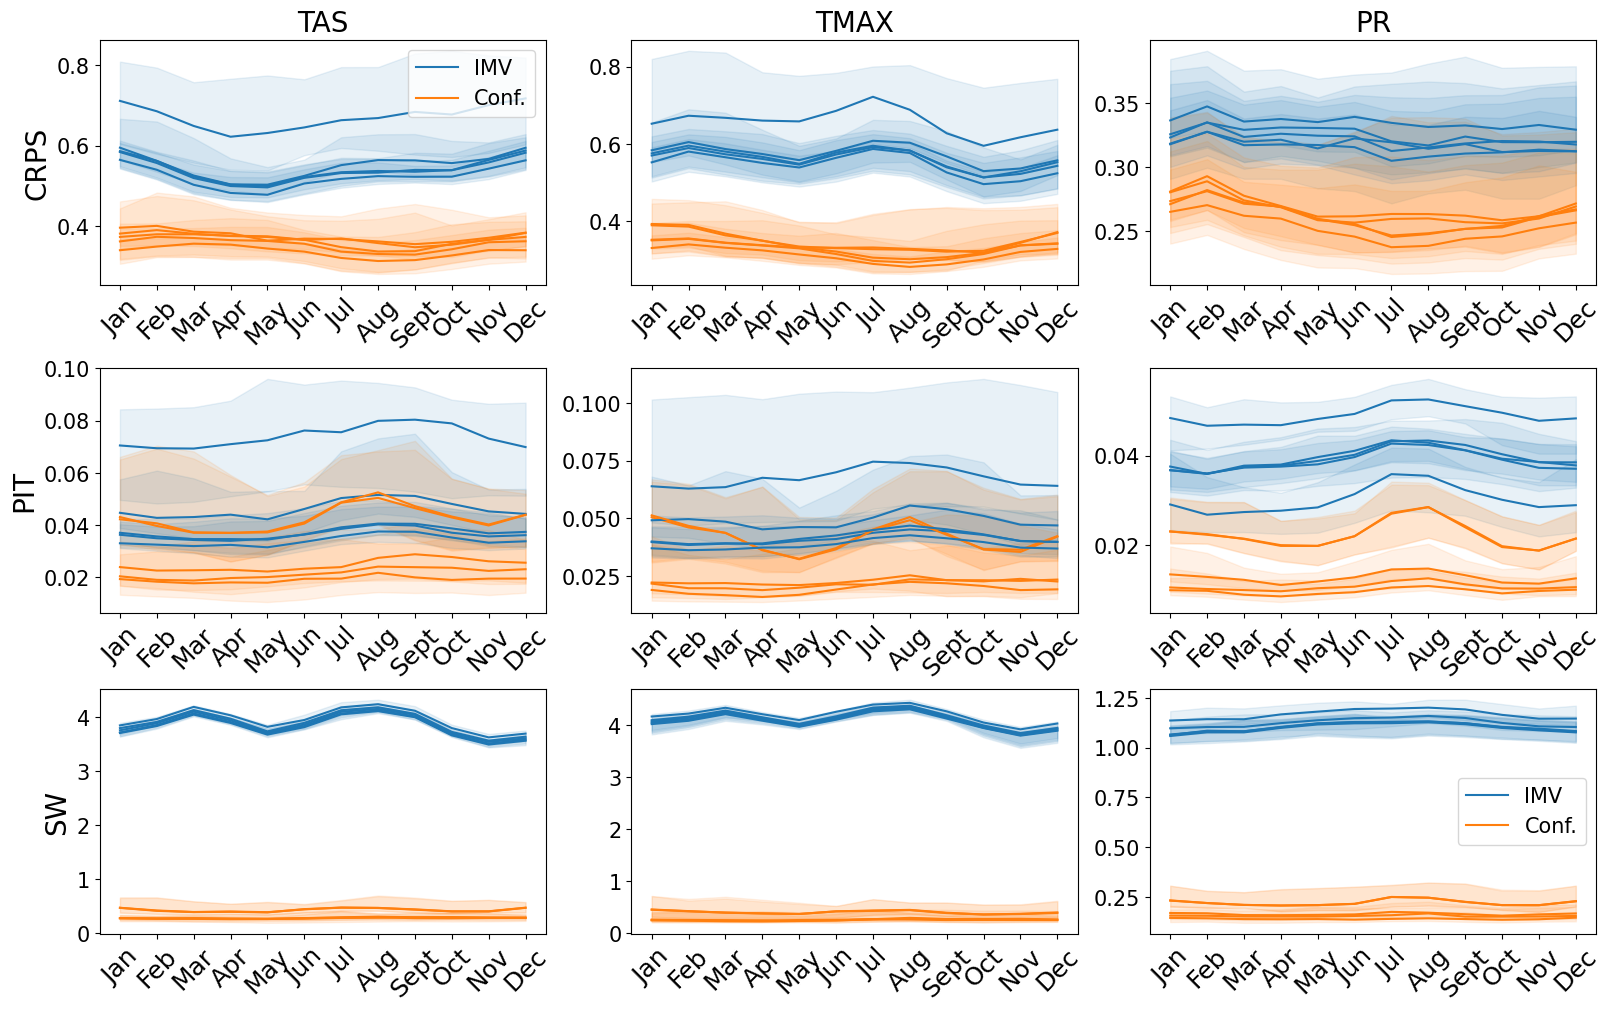

In [27]:
analysis = ['ens', 'wa', 'delta', 'lm', 'nngp', 'cnn1']
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
climvar = ['TAS', 'TMAX', 'PR']
s = np.arange(12)

fig, ax = plt.subplots(3, 3, constrained_layout = True, figsize = (16, 10))

for i in range(3):

    for k in range(0, 2*nproj, 2):

        mean_imv = np.median(all_results[i][:,k,:,1], axis = 0)
        lower_imv = np.quantile(all_results[i][:,k,:,1], 0.1, axis = 0)
        upper_imv = np.quantile(all_results[i][:,k,:,1], 0.9, axis = 0)

        mean_conf = np.median(all_results[i][:,k+1,:,1], axis = 0)
        lower_conf = np.quantile(all_results[i][:,k+1,:,1], 0.1, axis = 0)
        upper_conf = np.quantile(all_results[i][:,k+1,:,1], 0.9, axis = 0)

        if analysis[k//2] != 'lm':
            ax[0,i].fill_between(s, lower_imv, upper_imv, alpha = 0.1, color = 'C0')
            ax[0,i].plot(mean_imv.T, c = 'C0')

            ax[0,i].fill_between(s, lower_conf, upper_conf, alpha = 0.1, color = 'C1')
            ax[0,i].plot(mean_conf.T, c = 'C1')
            
    ax[0,i].plot([],[], c = 'C0', label = 'IMV')
    ax[0,i].plot([],[], c = 'C1', label = 'Conf.')
    ax[0,i].set_xticks(s, months, fontsize = 18, rotation=45)
    ax[0,i].set_title(climvar[i], fontsize = 20)
    ax[0,0].set_ylabel('CRPS', fontsize = 20)
    ax[0,i].yaxis.set_tick_params(labelsize=15)
    if i == 0:
        ax[0,i].legend(fontsize = 15, loc = 'upper right')
        
        
    for k in range(0, 2*nproj, 2):

        mean_imv = np.median(all_results[i][:,k,:,2], axis = 0)
        lower_imv = np.quantile(all_results[i][:,k,:,2], 0.1, axis = 0)
        upper_imv = np.quantile(all_results[i][:,k,:,2], 0.9, axis = 0)

        mean_conf = np.median(all_results[i][:,k+1,:,2], axis = 0)
        lower_conf = np.quantile(all_results[i][:,k+1,:,2], 0.1, axis = 0)
        upper_conf = np.quantile(all_results[i][:,k+1,:,2], 0.9, axis = 0)

        if analysis[k//2] != 'lm':
            ax[1,i].fill_between(s, lower_imv, upper_imv, alpha = 0.1, color = 'C0')
            ax[1,i].plot(mean_imv.T, c = 'C0')

            ax[1,i].fill_between(s, lower_conf, upper_conf, alpha = 0.1, color = 'C1')
            ax[1,i].plot(mean_conf.T, c = 'C1')
            
    ax[1,i].plot([],[], c = 'C0', label = 'IMV')
    ax[1,i].plot([],[], c = 'C1', label = 'Conf.')
    ax[1,i].set_xticks(s, months, fontsize = 18, rotation=45)
#     ax[1,i].set_title(climvar[i], fontsize = 20)
    ax[1,0].set_ylabel('PIT', fontsize = 20)
    ax[1,i].yaxis.set_tick_params(labelsize=15)
#     if i == 0:
#         ax[0,i].legend(fontsize = 15, loc = 'upper right')
        
        
    for k in range(0, 2*nproj, 2):

        mean_imv = np.median(all_results[i][:,k,:,-1], axis = 0)
        lower_imv = np.quantile(all_results[i][:,k,:,-1], 0.1, axis = 0)
        upper_imv = np.quantile(all_results[i][:,k,:,-1], 0.9, axis = 0)

        mean_conf = np.median(all_results[i][:,k+1,:,-1], axis = 0)
        lower_conf = np.quantile(all_results[i][:,k+1,:,-1], 0.1, axis = 0)
        upper_conf = np.quantile(all_results[i][:,k+1,:,-1], 0.9, axis = 0)

        if analysis[k//2] != 'lm':
            ax[2,i].fill_between(s, lower_imv, upper_imv, alpha = 0.1, color = 'C0')
            ax[2,i].plot(mean_imv.T, c = 'C0')

            ax[2,i].fill_between(s, lower_conf, upper_conf, alpha = 0.1, color = 'C1')
            ax[2,i].plot(mean_conf.T, c = 'C1')
            
    ax[2,i].plot([],[], c = 'C0', label = 'IMV')
    ax[2,i].plot([],[], c = 'C1', label = 'Conf.')
    ax[2,i].set_xticks(s, months, fontsize = 18, rotation=45)
#     ax[2,i].set_title(climvar[i], fontsize = 20)
    ax[2,0].set_ylabel('SW', fontsize = 20)
    ax[2,i].yaxis.set_tick_params(labelsize=15)
    if i == 2:
        ax[2,i].legend(fontsize = 15)

plt.show()